# GSMM mixture modelling with synthetic data

## Import packages and functions

In [31]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter
using PyPlot
using Clustering

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


In [2]:
include("../extensions/complex_gaussian.jl")
include("../extensions/hgf.jl")
include("../functions/auxiliary/workflow.jl")


em (generic function with 1 method)

## Generate data

In [3]:
# generate data
import Distributions: Normal, MvNormal, MixtureModel, Dirichlet
nr_samples = 200
nr_freqs = 5

# simulate 3 clusters
μ_ξi1 = 1.0*collect(1:1:1*nr_freqs)
μ_ξi2 = 1.0*collect(2:2:2*nr_freqs)
μ_ξi3 = 1.0*collect(3:3:3*nr_freqs)
Σ_ξ = 1e-4*diagm(ones(nr_freqs))
Σ_meas = 1e-10*diagm(ones(nr_freqs))

# create arrays for samples
cluster_id = Array{Int64,1}(undef, nr_samples)
ξ_samples = Array{Array{Float64,1},1}(undef, nr_samples)
X_samples = Array{Array{Complex{Float64},1},1}(undef, nr_samples)
y_samples = Array{Array{Complex{Float64},1},1}(undef, nr_samples)

for n = 1:nr_samples
     
    # create arrays for frequencies
    ξ_samples[n] = Array{Float64,1}(undef, nr_freqs)
    X_samples[n] = Array{Complex{Float64},1}(undef, nr_freqs)
    y_samples[n] = Array{Complex{Float64},1}(undef, nr_freqs)
    
    # randomly pick cluster to get means from 
    cluster_id[n] = rand([1,2,3])
    if cluster_id[n] == 1
        μ_ξi = μ_ξi1
    elseif cluster_id[n] == 2
        μ_ξi = μ_ξi2
    else
        μ_ξi = μ_ξi3
    end
    
    for k = 1:nr_freqs
        sample_ξ = rand(Normal(μ_ξi[k], sqrt(Σ_ξ[k,k])))
        sample_X = rand(Normal(0, sqrt(0.5*exp(sample_ξ)))) + 1im*rand(Normal(0, sqrt(0.5*exp(sample_ξ))))
        sample_y = rand(Normal(real(sample_X), sqrt(0.5*Σ_meas[k,k]))) + 1im*rand(Normal(imag(sample_X), sqrt(0.5*Σ_meas[k,k])))

        ξ_samples[n][k] = sample_ξ
        X_samples[n][k] = sample_X
        y_samples[n][k] = sample_y
    end
end

t = collect(1:nr_samples)
Y = y_samples;

# Building graph

In [44]:
# initialization:

# reshape Y
Yi = hcat(Y...)

# approximate with log-power
Yi = log.(abs2.(Yi))

# perform kmeans clustering
prior_m = kmeans(Yi,3).centers

5×3 Array{Float64,2}:
  2.14534  1.43136  0.642731
  5.41235  3.54664  1.74032 
  8.68259  5.55036  2.45118 
 11.5115   7.38773  3.52773 
 14.4964   9.48162  4.12023 

In [221]:
#nr_freqs = dimension

nr_clusters = 3

fg = FactorGraph()
α = 0.1
# Specify generative model
@RV _pi ~ ForneyLab.Dirichlet(α*ones(nr_clusters))
@RV w_1 ~ Wishart(diagm(ones(nr_freqs)), nr_freqs+2)
@RV m_1 ~ GaussianMeanPrecision(prior_m[:,1], w_1)
@RV w_2 ~ Wishart(diagm(ones(nr_freqs)), nr_freqs+2)
@RV m_2 ~ GaussianMeanPrecision(prior_m[:,2], w_2)
@RV w_3 ~ Wishart(diagm(ones(nr_freqs)), nr_freqs+2)
@RV m_3 ~ GaussianMeanPrecision(prior_m[:,3], w_3)

z = Vector{Variable}(undef, nr_samples)
ξ = Vector{Variable}(undef, nr_samples)
X = Vector{Variable}(undef, nr_samples)
y = Vector{Variable}(undef, nr_samples)
for i in 1:nr_samples
    @RV z[i] ~ Categorical(_pi)
    @RV ξ[i] ~ GaussianMixture(z[i], m_1, w_1, m_2, w_2, m_3, w_3)
    # HGF
    @RV X[i] ~ HGF(ξ[i])

    # observation model
    @RV y[i] ~ ComplexNormal(X[i], 1e-10*diagm(ones(nr_freqs)).+0im, mat(0.0+0.0im))
    
    
    placeholder(y[i], :y, index=i, dims=(nr_freqs,))
end
# draw graph
# ForneyLab.draw(fg)

In [222]:
# Build the algorithm
q = PosteriorFactorization(_pi, m_1, w_1, m_2, w_2, m_3, w_3, z, X, ξ, ids=[:PI :M1 :W1 :M2 :W2 :M3 :W3 :Z :X :Ξ])
algo = variationalAlgorithm(q)

# Generate source code
source_code = algorithmSourceCode(algo);

# Load algorithm
eval(Meta.parse(source_code));

In [178]:
# println(source_code)

In [223]:
data = Dict(:y => Y)

# Prepare posterior factors
marginals = Dict(:_pi => vague(ForneyLab.Dirichlet, nr_clusters),
                 :m_1 => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=prior_m[:,1], w=1e0*diagm(ones(nr_freqs))),
                 :w_1 => ProbabilityDistribution(MatrixVariate, ForneyLab.Wishart, v=1e0*diagm(ones(nr_freqs)), nu=nr_freqs),
                 :m_2 => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=prior_m[:,2], w=1e0*diagm(ones(nr_freqs))),
                 :w_2 => ProbabilityDistribution(MatrixVariate, ForneyLab.Wishart, v=1e0*diagm(ones(nr_freqs)), nu=nr_freqs),
                 :m_3 => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=prior_m[:,3], w=1e0*diagm(ones(nr_freqs))),
                 :w_3 => ProbabilityDistribution(MatrixVariate, ForneyLab.Wishart, v=1e0*diagm(ones(nr_freqs)), nu=nr_freqs))
for i in 1:nr_samples
    marginals[:z_*i] = vague(Categorical)
    marginals[:X_*i] = ProbabilityDistribution(Multivariate, ComplexNormal, μ=zeros(nr_freqs) .+ 0.0im, Γ=1e-10*diagm(ones(nr_freqs)).+0im, C=mat(0.0+0.0im));
    marginals[:ξ_*i] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=zeros(nr_freqs), v=diagm(ones(nr_freqs)))
end



In [224]:
# Execute algorithm
nr_its = 10
@showprogress for i in 1:nr_its
    stepX!(data, marginals)
    stepΞ!(data, marginals)
    stepZ!(data, marginals)
    stepPI!(data, marginals)
    stepM1!(data, marginals)
    stepW1!(data, marginals)
    stepM2!(data, marginals)
    stepW2!(data, marginals) 
    stepM3!(data, marginals)
    stepW3!(data, marginals)   
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:16


In [225]:
marginals[:_pi]

Dir(a=[0.10, 2.00e+02, 0.10])


In [226]:
prior_m

5×3 Array{Float64,2}:
  2.14534  1.43136  0.642731
  5.41235  3.54664  1.74032 
  8.68259  5.55036  2.45118 
 11.5115   7.38773  3.52773 
 14.4964   9.48162  4.12023 

In [227]:
ForneyLab.unsafeMean(marginals[:m_1])

5-element Array{Float64,1}:
  2.145344926929221
  5.412354446839972
  8.68259110995245 
 11.511530070314059
 14.496391873751852

In [228]:
ForneyLab.unsafeMean(marginals[:m_2])

5-element Array{Float64,1}:
  1.5093410378787202
  3.8114907088664065
  5.978479711819626 
  8.005259890237896 
 10.071545718522128 

In [229]:
ForneyLab.unsafeMean(marginals[:m_3])

5-element Array{Float64,1}:
 0.6427306836304668
 1.7403213977771588
 2.451184663761332 
 3.527725150879931 
 4.120234106964631 

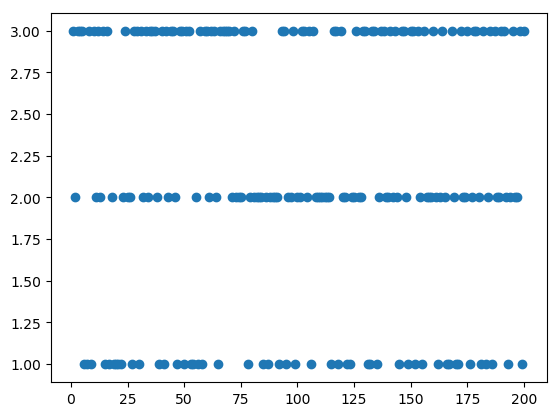

PyObject <matplotlib.collections.PathCollection object at 0x0000000065FB2CC0>

In [230]:
plt.scatter(t,cluster_id)

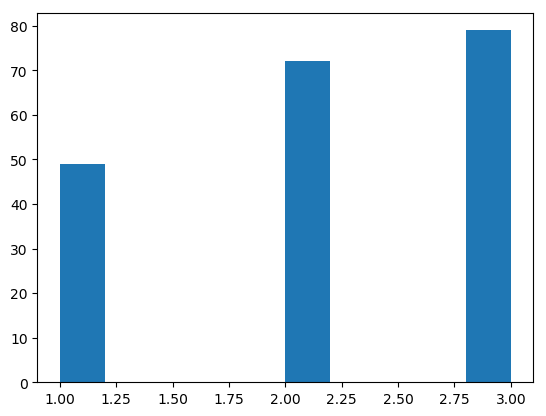

([49.0, 0.0, 0.0, 0.0, 0.0, 72.0, 0.0, 0.0, 0.0, 79.0], [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4000000000000004, 2.6, 2.8, 3.0], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x0000000069BBFB00>, PyObject <matplotlib.patches.Rectangle object at 0x0000000069BBF908>, PyObject <matplotlib.patches.Rectangle object at 0x0000000069BC7160>, PyObject <matplotlib.patches.Rectangle object at 0x0000000069BC74A8>, PyObject <matplotlib.patches.Rectangle object at 0x0000000069BC77F0>, PyObject <matplotlib.patches.Rectangle object at 0x0000000069BC7B38>, PyObject <matplotlib.patches.Rectangle object at 0x0000000069BC7E80>, PyObject <matplotlib.patches.Rectangle object at 0x0000000069BD3208>, PyObject <matplotlib.patches.Rectangle object at 0x0000000069BD3550>, PyObject <matplotlib.patches.Rectangle object at 0x0000000069BD3898>])

In [231]:
plt.hist(cluster_id)

In [232]:
z_inferred = [findmax(marginals[:z_*k].params[:p])[2] for k = 1:nr_samples];

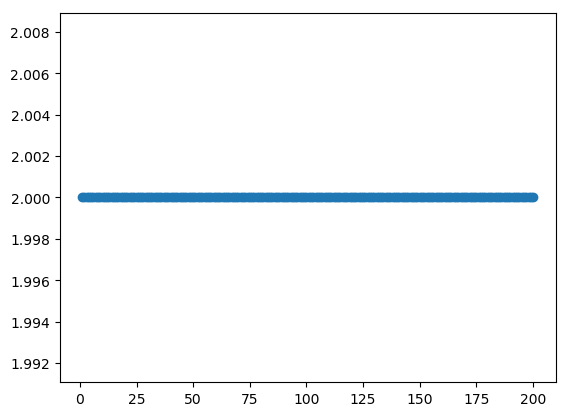

PyObject <matplotlib.collections.PathCollection object at 0x00000000697ECE80>

In [233]:
plt.scatter(t,z_inferred)